## Linear morph on test data

### Setup

In [1]:
%load_ext autoreload
%autoreload 3 --print

In [2]:
from kpsn.models.morph import affine_mode as afm
from kpsn.models.morph import scalar 
from kpsn.models.pose import gmm
from kpsn.models import joint_model
from kpsn.fitting import em
from kpsn import models
from kpsn import util

from kpsn_test.visualize import mixtures
from kpsn_test.visualize import morphs as viz_morphs

import jax.numpy as jnp
import jax.random as jr
import jax.nn as jnn
import numpy as np
import optax
import jax
from tensorflow_probability.substrates import jax as tfp
from typing import Callable, Tuple

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors
from matplotlib import gridspec

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

### Sample dataset

In [4]:
T = 500; N = 3; M = 2; L = 5; eps = 0.05; morph_L = 1
morph_hyperparams = afm.AffineModeMorphHyperparams(
    N = N, M = M, L = morph_L, modes=None, update_scale = 0.3)
pose_hyperparams = gmm.GMMHyperparams(
    N = N, M = M, L = L, eps = eps,
    pop_weight_uniformity = 10,
    subj_weight_uniformity = 100)
model = joint_model.JointModel(morph = afm.AffineModeMorph, posespace = gmm.GMMPoseSpaceModel)
hyperparams = joint_model.JointHyperparams(morph = morph_hyperparams, posespace = pose_hyperparams)

gt_morph, gt_pose, gt_latents, gt_obs = joint_model.sample(
    jr.PRNGKey(0), T,
    model,
    hyperparams,
    dict(
        uniform_scale_std = 0.1,
        mode_std = 0.3,
        update_std = 0.3,
        offset_std = 0.6
    ),
    dict(
        # pi_logit_means = jnp.stack([2 * jnp.exp(jnp.linspace(-i_subj / 5, i_subj / 5, L))
                                    # for i_subj in range(pose_hyperparams.N)]),
        # pi_logit_vars = 0.06 * jnp.ones([N, L]),
        m_norm_center = 2,
        m_norm_spread = 0.4,
        q_var_center = 0.5,
        q_var_spread = 0.1),
)

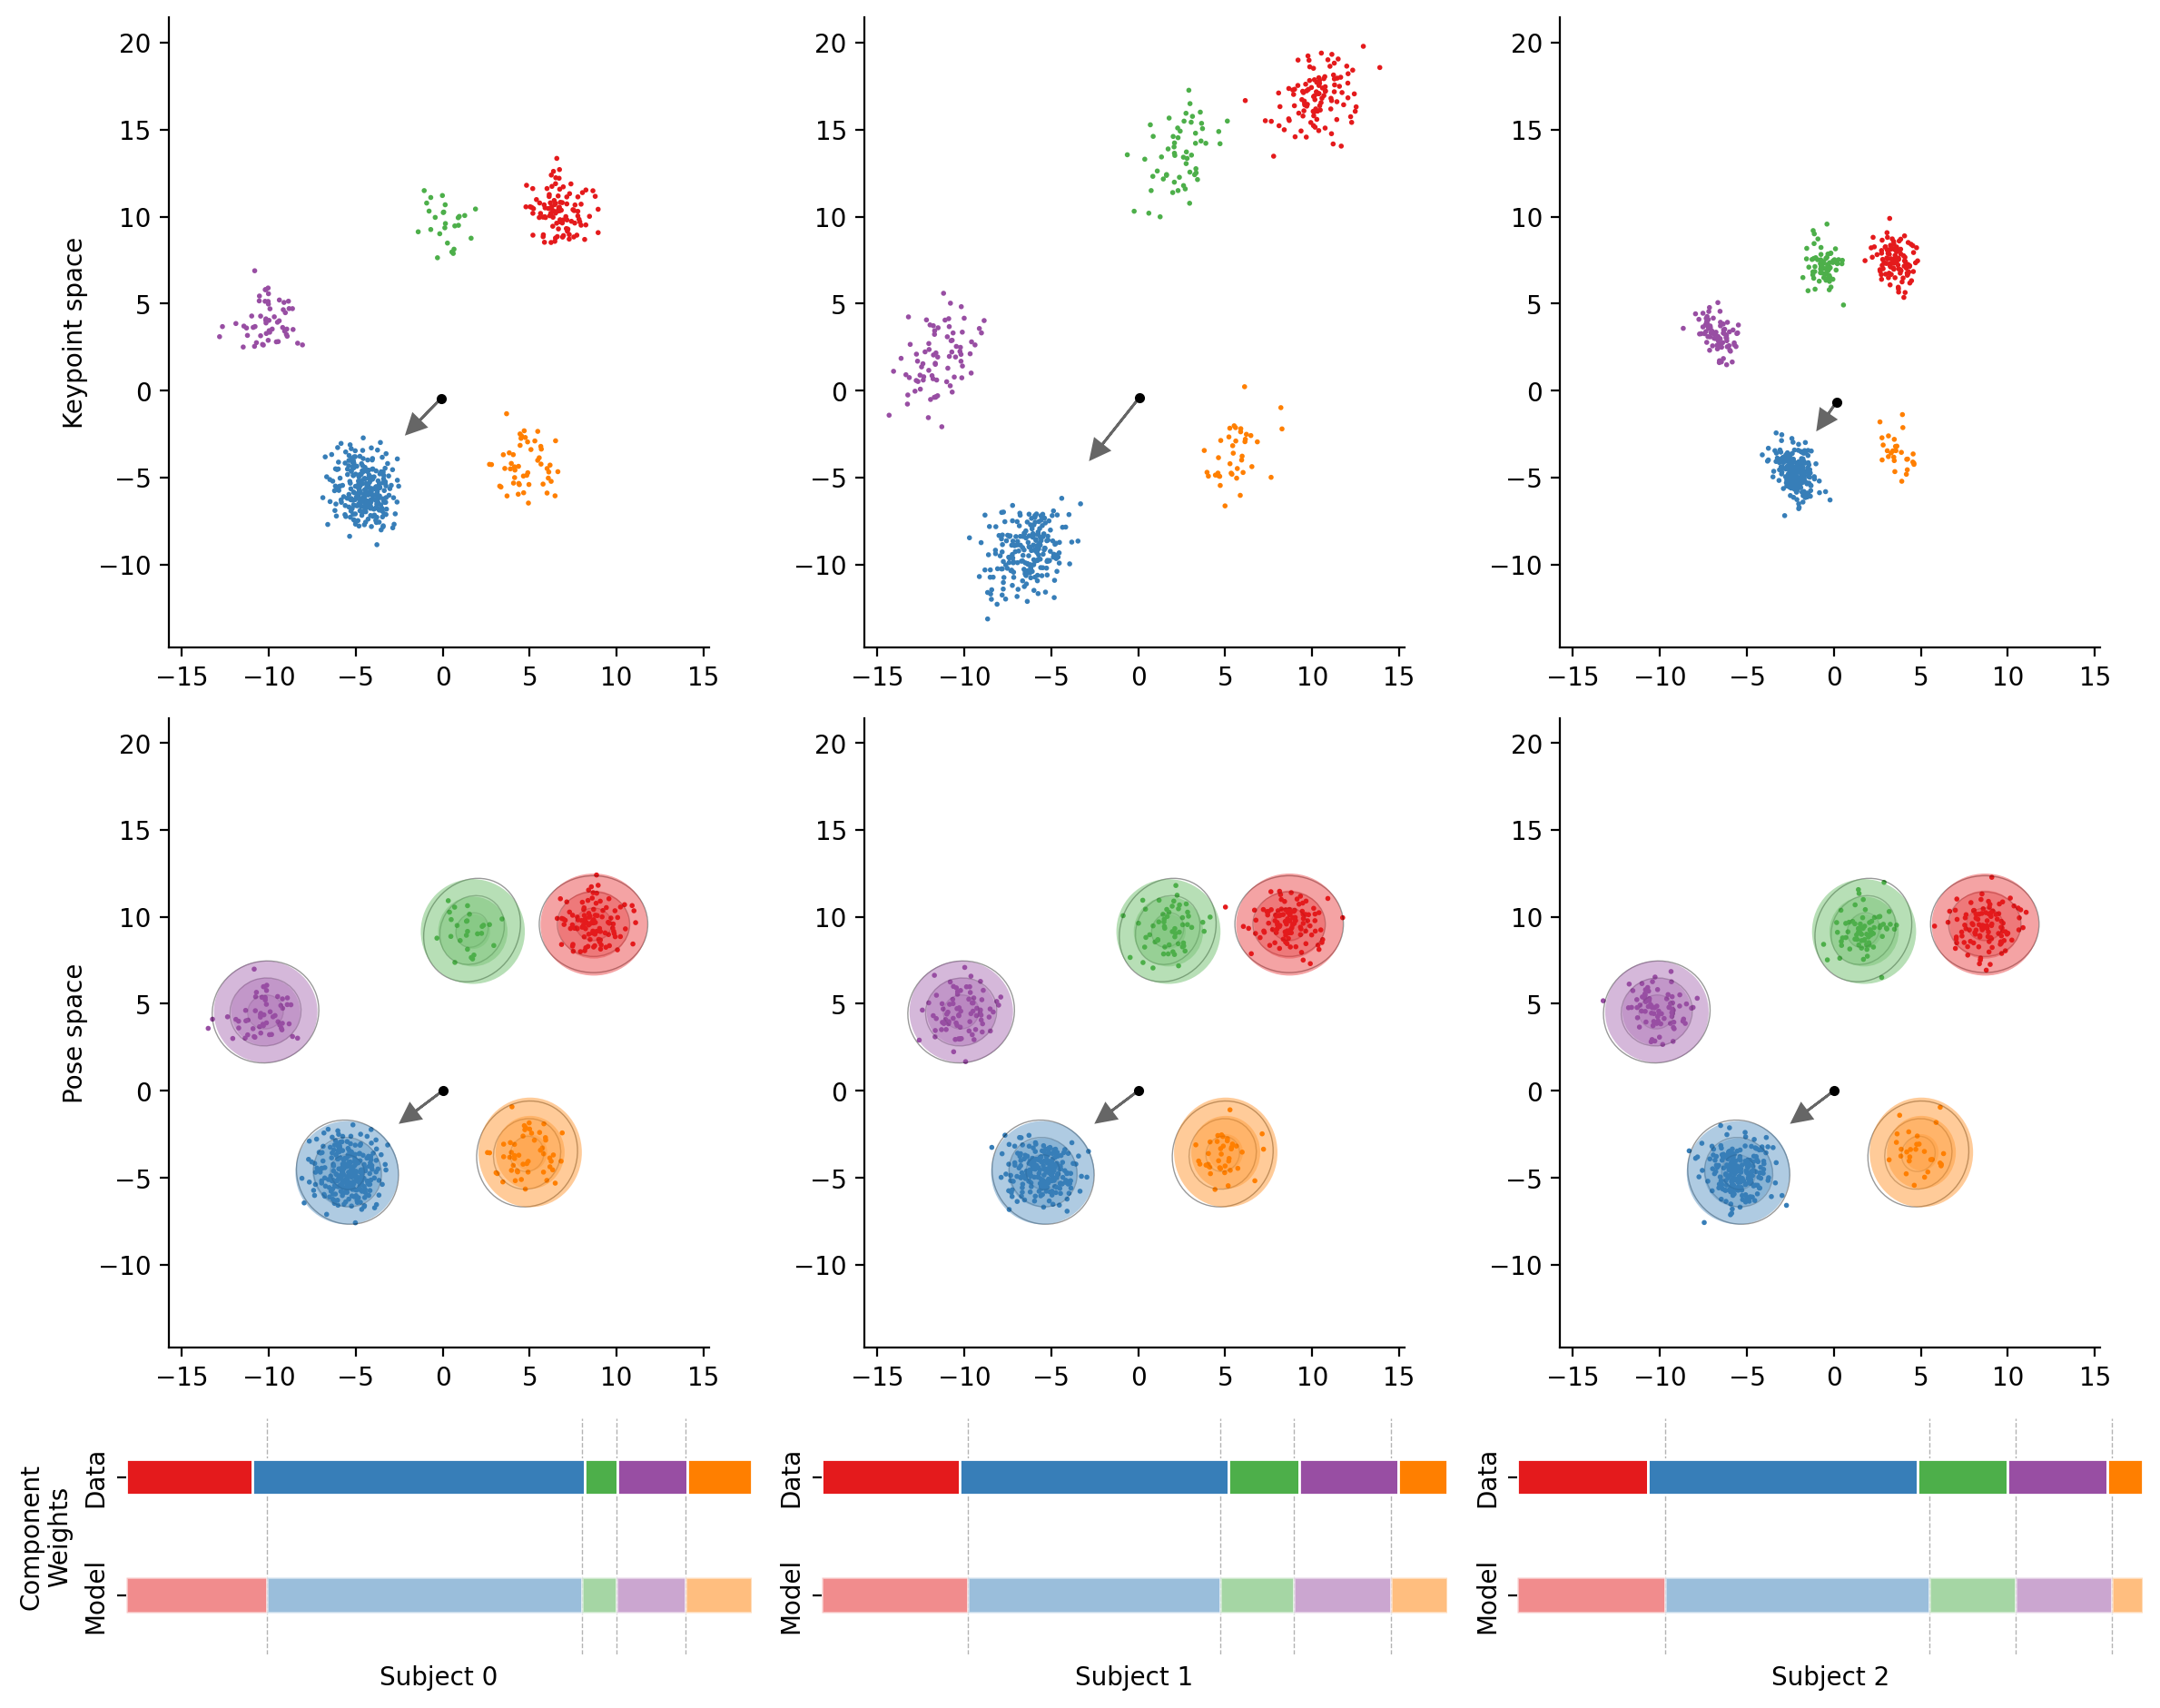

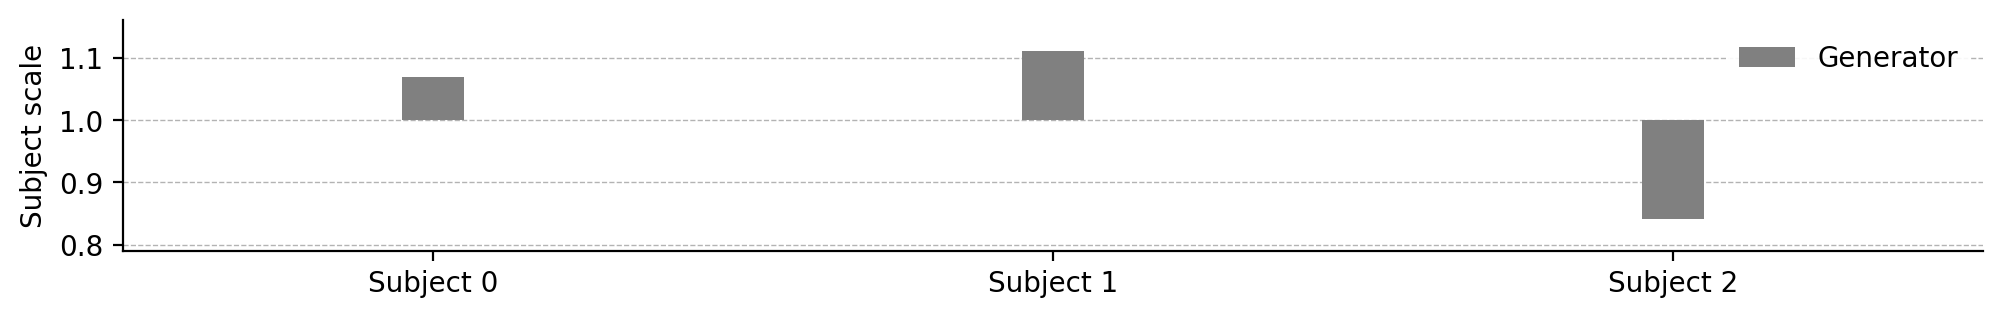

In [5]:
fig = plt.figure(figsize = (4 * pose_hyperparams.N, 8 + 1.5 + 1.5))
ax = mixtures.sampled_mixture_plot(fig, pose_hyperparams, gt_pose, gt_latents, gt_obs)
viz_morphs.plot_morph_dimensions(
    ax, morph_hyperparams, afm.AffineModeMorph, gt_morph, display_scale = 3)
fig = plt.figure(figsize = (4 * pose_hyperparams.N, 1.5))

viz_morphs.plot_subjectwise_scalar_comparison(
    fig.gca(),
    [jnp.exp(gt_morph.uniform_scale())],
    ["Generator",],)

### Single M-Step

In [17]:

loss_hist, fit_params = em._mstep(
    model = model,
    # init_params = smgmm_test.pertub_parameters(jr.PRNGKey(1), smgmm_data.params, 0.0),
    # estimated_params = smgmm_test.pertub_parameters(jr.PRNGKey(0), smgmm_data.params, 0.0),
    init_params = joint_model.JointParameters(posespace = gt_pose, morph = gt_morph),
    estimated_params = joint_model.JointParameters(posespace = gt_pose, morph = gt_morph),
    emissions = gt_obs,
    hyperparams = hyperparams,
    optimizer = optax.adam(learning_rate=5e-4),
    n_steps = 2000,
    log_every = -1,
    progress = False
)



TypeError: _mstep() got an unexpected keyword argument 'estimated_params'

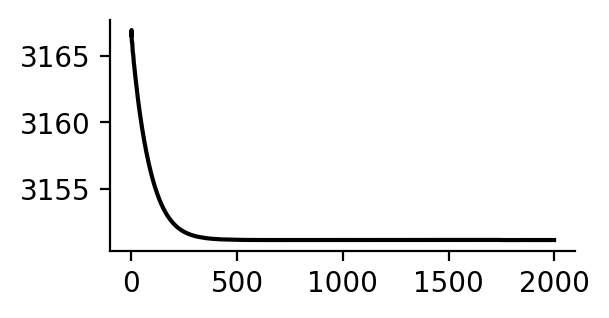

In [11]:
plt.figure(figsize = (3, 1.5))
plt.plot(loss_hist, 'k-')
sns.despine()

In [23]:
fig = plt.figure(figsize = (4 * pose_hyperparams.N, 8 + 1.5 + 1.5))
ax = mixtures.sampled_mixture_plot(fig, pose_hyperparams, fit_params.posespace, gt_latents, gt_obs)
viz_morphs.plot_morph_dimensions(ax[:2], morph_hyperparams, afm.AffineModeMorph, fit_params.morph, scale = 3)

Reloading 'kpsn.models.morph.affine_mode'.


NameError: name 'fit_params' is not defined

<Figure size 1200x1100 with 0 Axes>

### Initialization

In [6]:
init_params = joint_model.init(
    model,
    hyperparams,
    gt_obs,
    reference_subject = 0
)

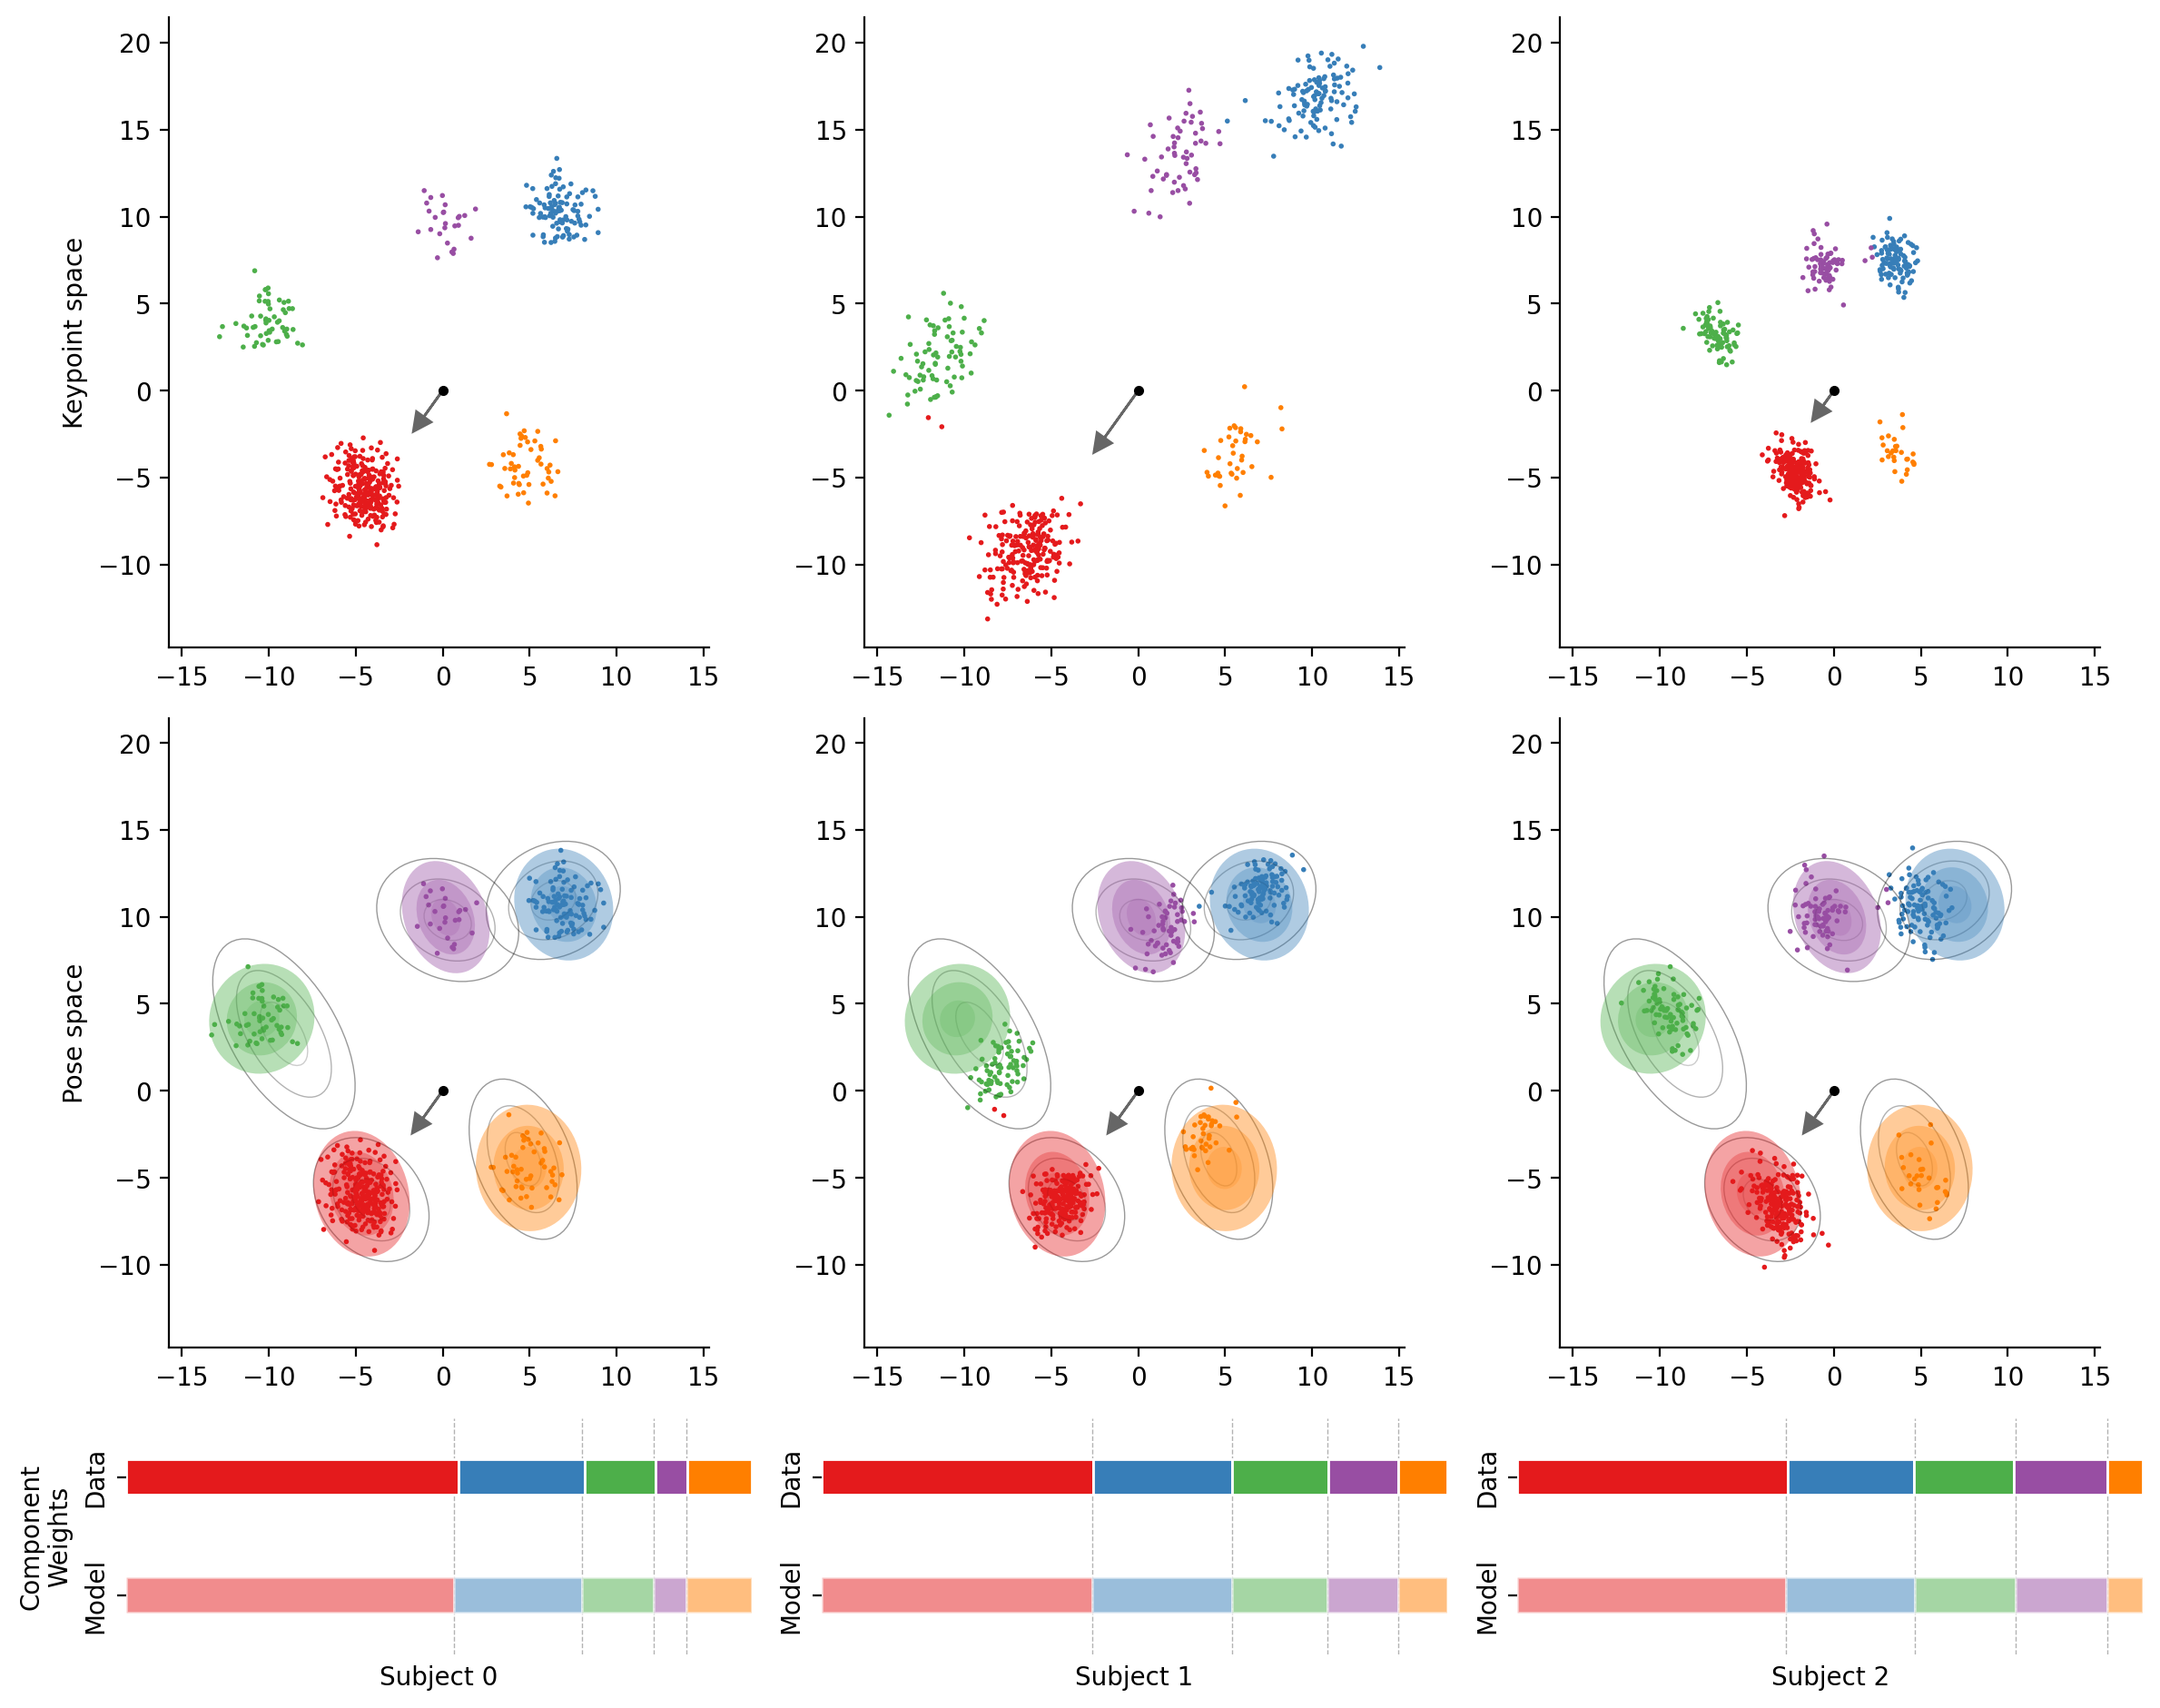

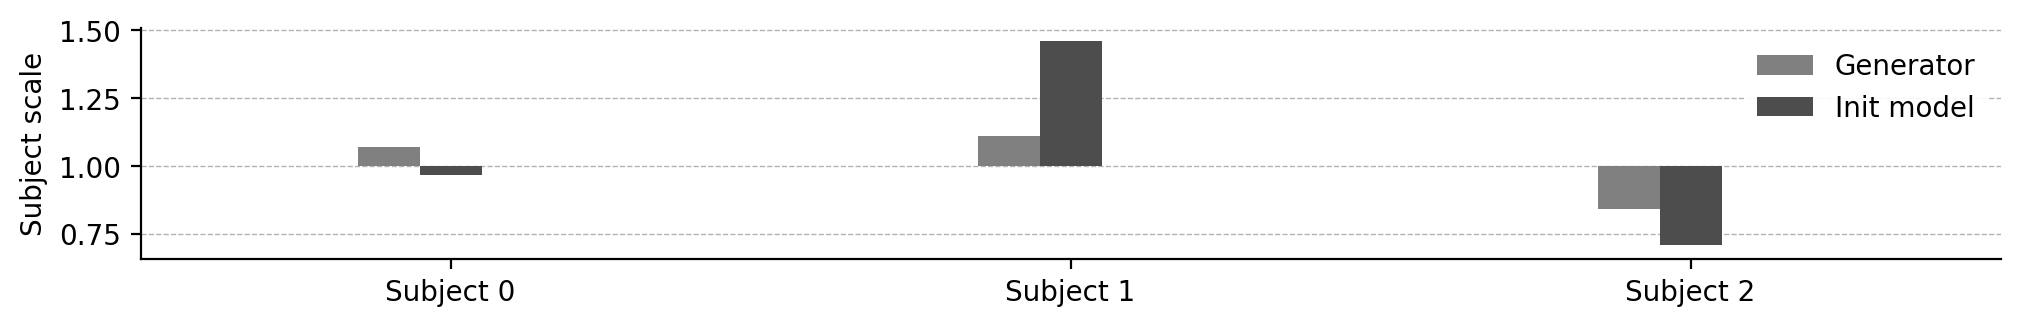

In [7]:
fig = plt.figure(figsize = (4 * pose_hyperparams.N, 8 + 1.5 + 1.5))
est_states = joint_model.latent_mle(model, gt_obs, init_params, hyperparams)
ax = mixtures.sampled_mixture_plot(fig, pose_hyperparams, init_params.posespace, est_states, gt_obs)
viz_morphs.plot_morph_dimensions(
    ax, morph_hyperparams, afm.AffineModeMorph, init_params.morph, display_scale = 3)
plt.show()

fig = plt.figure(figsize = (4 * pose_hyperparams.N, 1.5))
viz_morphs.plot_subjectwise_scalar_comparison(
    fig.gca(),
    [jnp.exp(gt_morph.uniform_scale()),
     jnp.exp(init_params.morph.uniform_scale())],
    ["Generator", "Init model"],)

### Iterated EM

In [12]:
loss_hist, fit_params, mstep_losses, param_hist = em.iterate_em(
    model = model,
    init_params = init_params,
    emissions = gt_obs,
    hyperparams = hyperparams,
    n_steps = 200,
    log_every = -1,
    progress = True,
    tol = None,
    batch_size = 50,
    mstep_tol = 1e-7,
    mstep_stop_window = 25,
    return_mstep_losses = True,
    return_param_hist = True
)

100%|██████████| 200/200 [00:10<00:00, 19.13it/s]


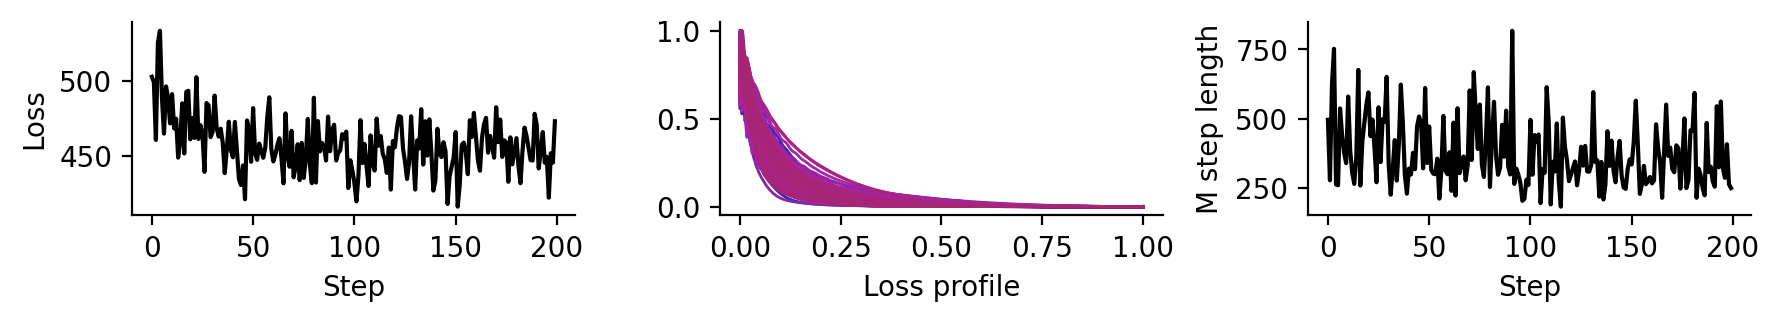

In [13]:
fig, ax = plt.subplots(figsize = (9, 1.7), ncols = 3)
ax[0].plot(loss_hist, 'k-')
pal = sns.hls_palette(len(mstep_losses) * 5, h = 0.7, l = 0.4)[:len(mstep_losses)]
lw = np.linspace(1, 1, len(mstep_losses))
mstep_lengths = []
for i in range(0, len(mstep_losses)):
    if np.any(~np.isfinite(mstep_losses[i])):
        curr_loss = mstep_losses[i][:np.argmax(~np.isfinite(mstep_losses[i]))]
        if len(curr_loss) == 0: continue
    else:
        curr_loss = mstep_losses[i]
    mstep_lengths.append(len(curr_loss))
    ax[1].plot(
        np.linspace(0, 1, len(curr_loss)),
        (curr_loss - curr_loss.min()) / (curr_loss.max() - curr_loss.min()),
        color = pal[i], lw = lw[i])
ax[2].plot(np.arange(len(mstep_lengths)), mstep_lengths, 'k-')
ax[1].set_xlabel("Loss profile")
ax[2].set_ylabel("M step length")
ax[2].set_xlabel("Step")
ax[0].set_ylabel("Loss")
ax[0].set_xlabel("Step")
plt.tight_layout()
sns.despine()

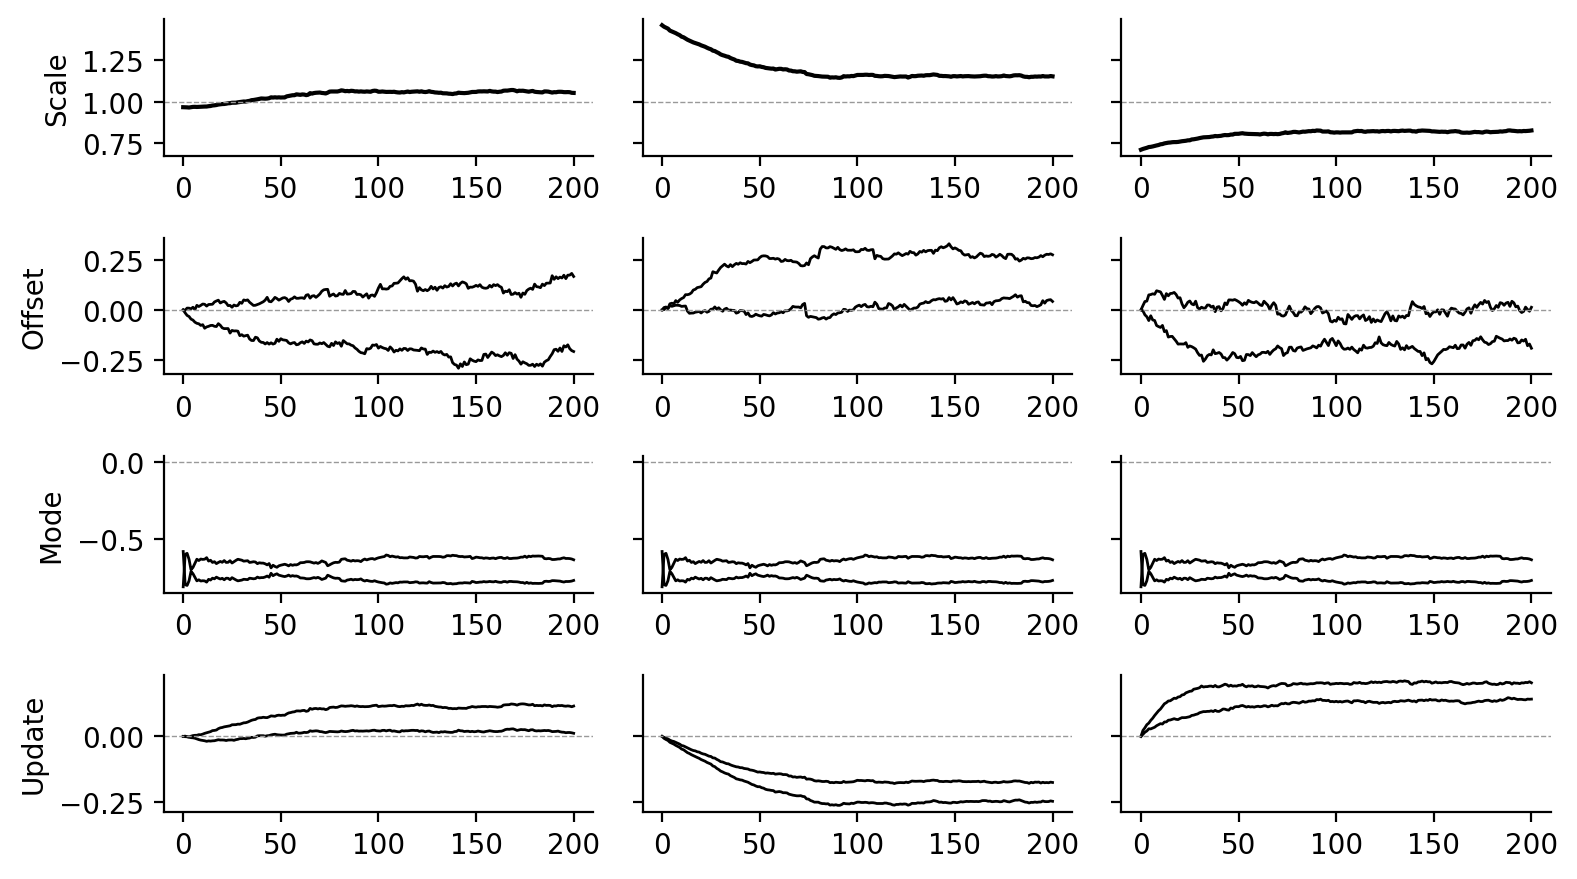

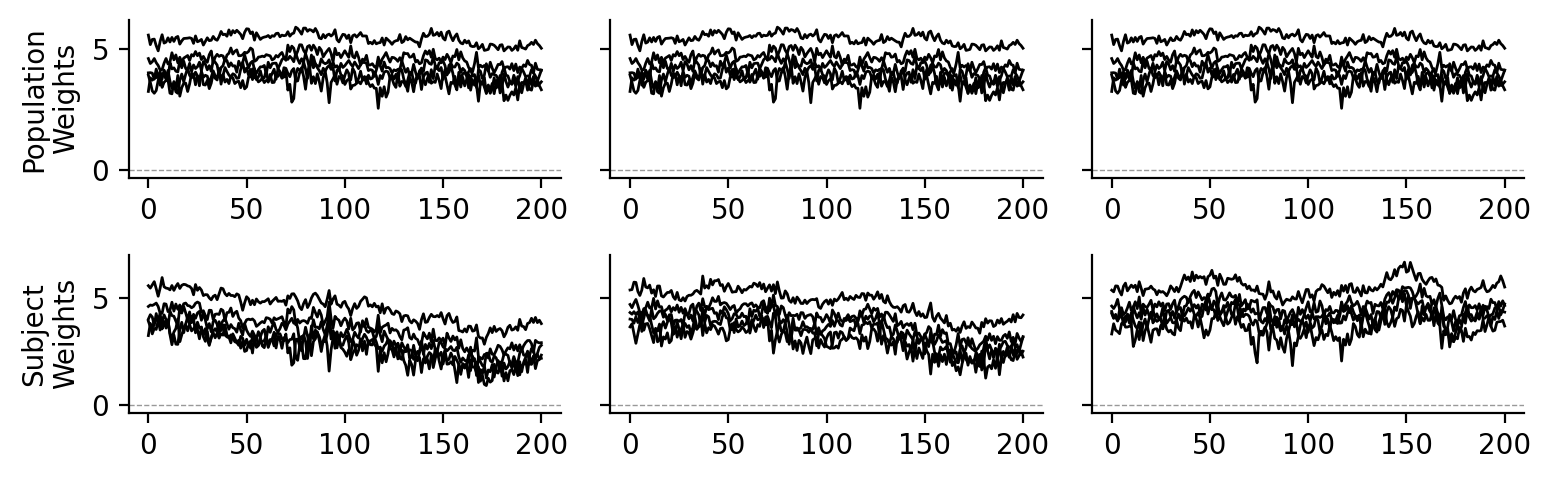

In [14]:
scale_hist = np.stack([p.morph.uniform_scale() for p in param_hist])
ofs_hist = np.stack([p.morph.offsets() for p in param_hist])
mode_hist = np.stack([p.morph.modes() for p in param_hist])
update_hist = np.stack([p.morph.updates() for p in param_hist])

pop_weight_hist = np.stack([p.posespace.pop_weight_logits for p in param_hist])
subj_weight_hist = np.stack([p.posespace.subj_weight_logits for p in param_hist])

fig, ax = plt.subplots(4, hyperparams.morph.N, figsize = (8, 4.5), sharey = 'row')
for subj_i in range(hyperparams.morph.N):
    ax[0, subj_i].plot(np.exp(scale_hist[:, subj_i]), 'k-')
    ax[0, subj_i].axhline(1, ls = '--', color = '.6', lw = 0.5)
    ax[1, subj_i].plot(ofs_hist[:, subj_i], 'k-', lw = 1)
    ax[2, subj_i].plot(mode_hist[:, :, 0], 'k-', lw = 1)
    ax[3, subj_i].plot(update_hist[:, subj_i, :, 0], 'k-', lw = 1)
    for i in [1, 2, 3]:
        ax[i, subj_i].axhline(0, ls = '--', color = '.6', lw = 0.5)
ax[0, 0].set_ylabel("Scale")
ax[1, 0].set_ylabel("Offset")
ax[2, 0].set_ylabel("Mode")
ax[3, 0].set_ylabel("Update")
sns.despine()
plt.tight_layout()


fig, ax = plt.subplots(2, hyperparams.morph.N, figsize = (8, 2.5), sharey = 'row')
for subj_i in range(hyperparams.morph.N):
    ax[0, subj_i].plot(pop_weight_hist, 'k-', lw = 1)
    ax[1, subj_i].plot(subj_weight_hist[:, subj_i], 'k-', lw = 1)
    for i in [0, 1]:
        ax[i, subj_i].axhline(0, ls = '--', color = '.6', lw = 0.5)
ax[0, 0].set_ylabel("Population\nWeights")
ax[1, 0].set_ylabel("Subject\nWeights")
sns.despine()
plt.tight_layout()

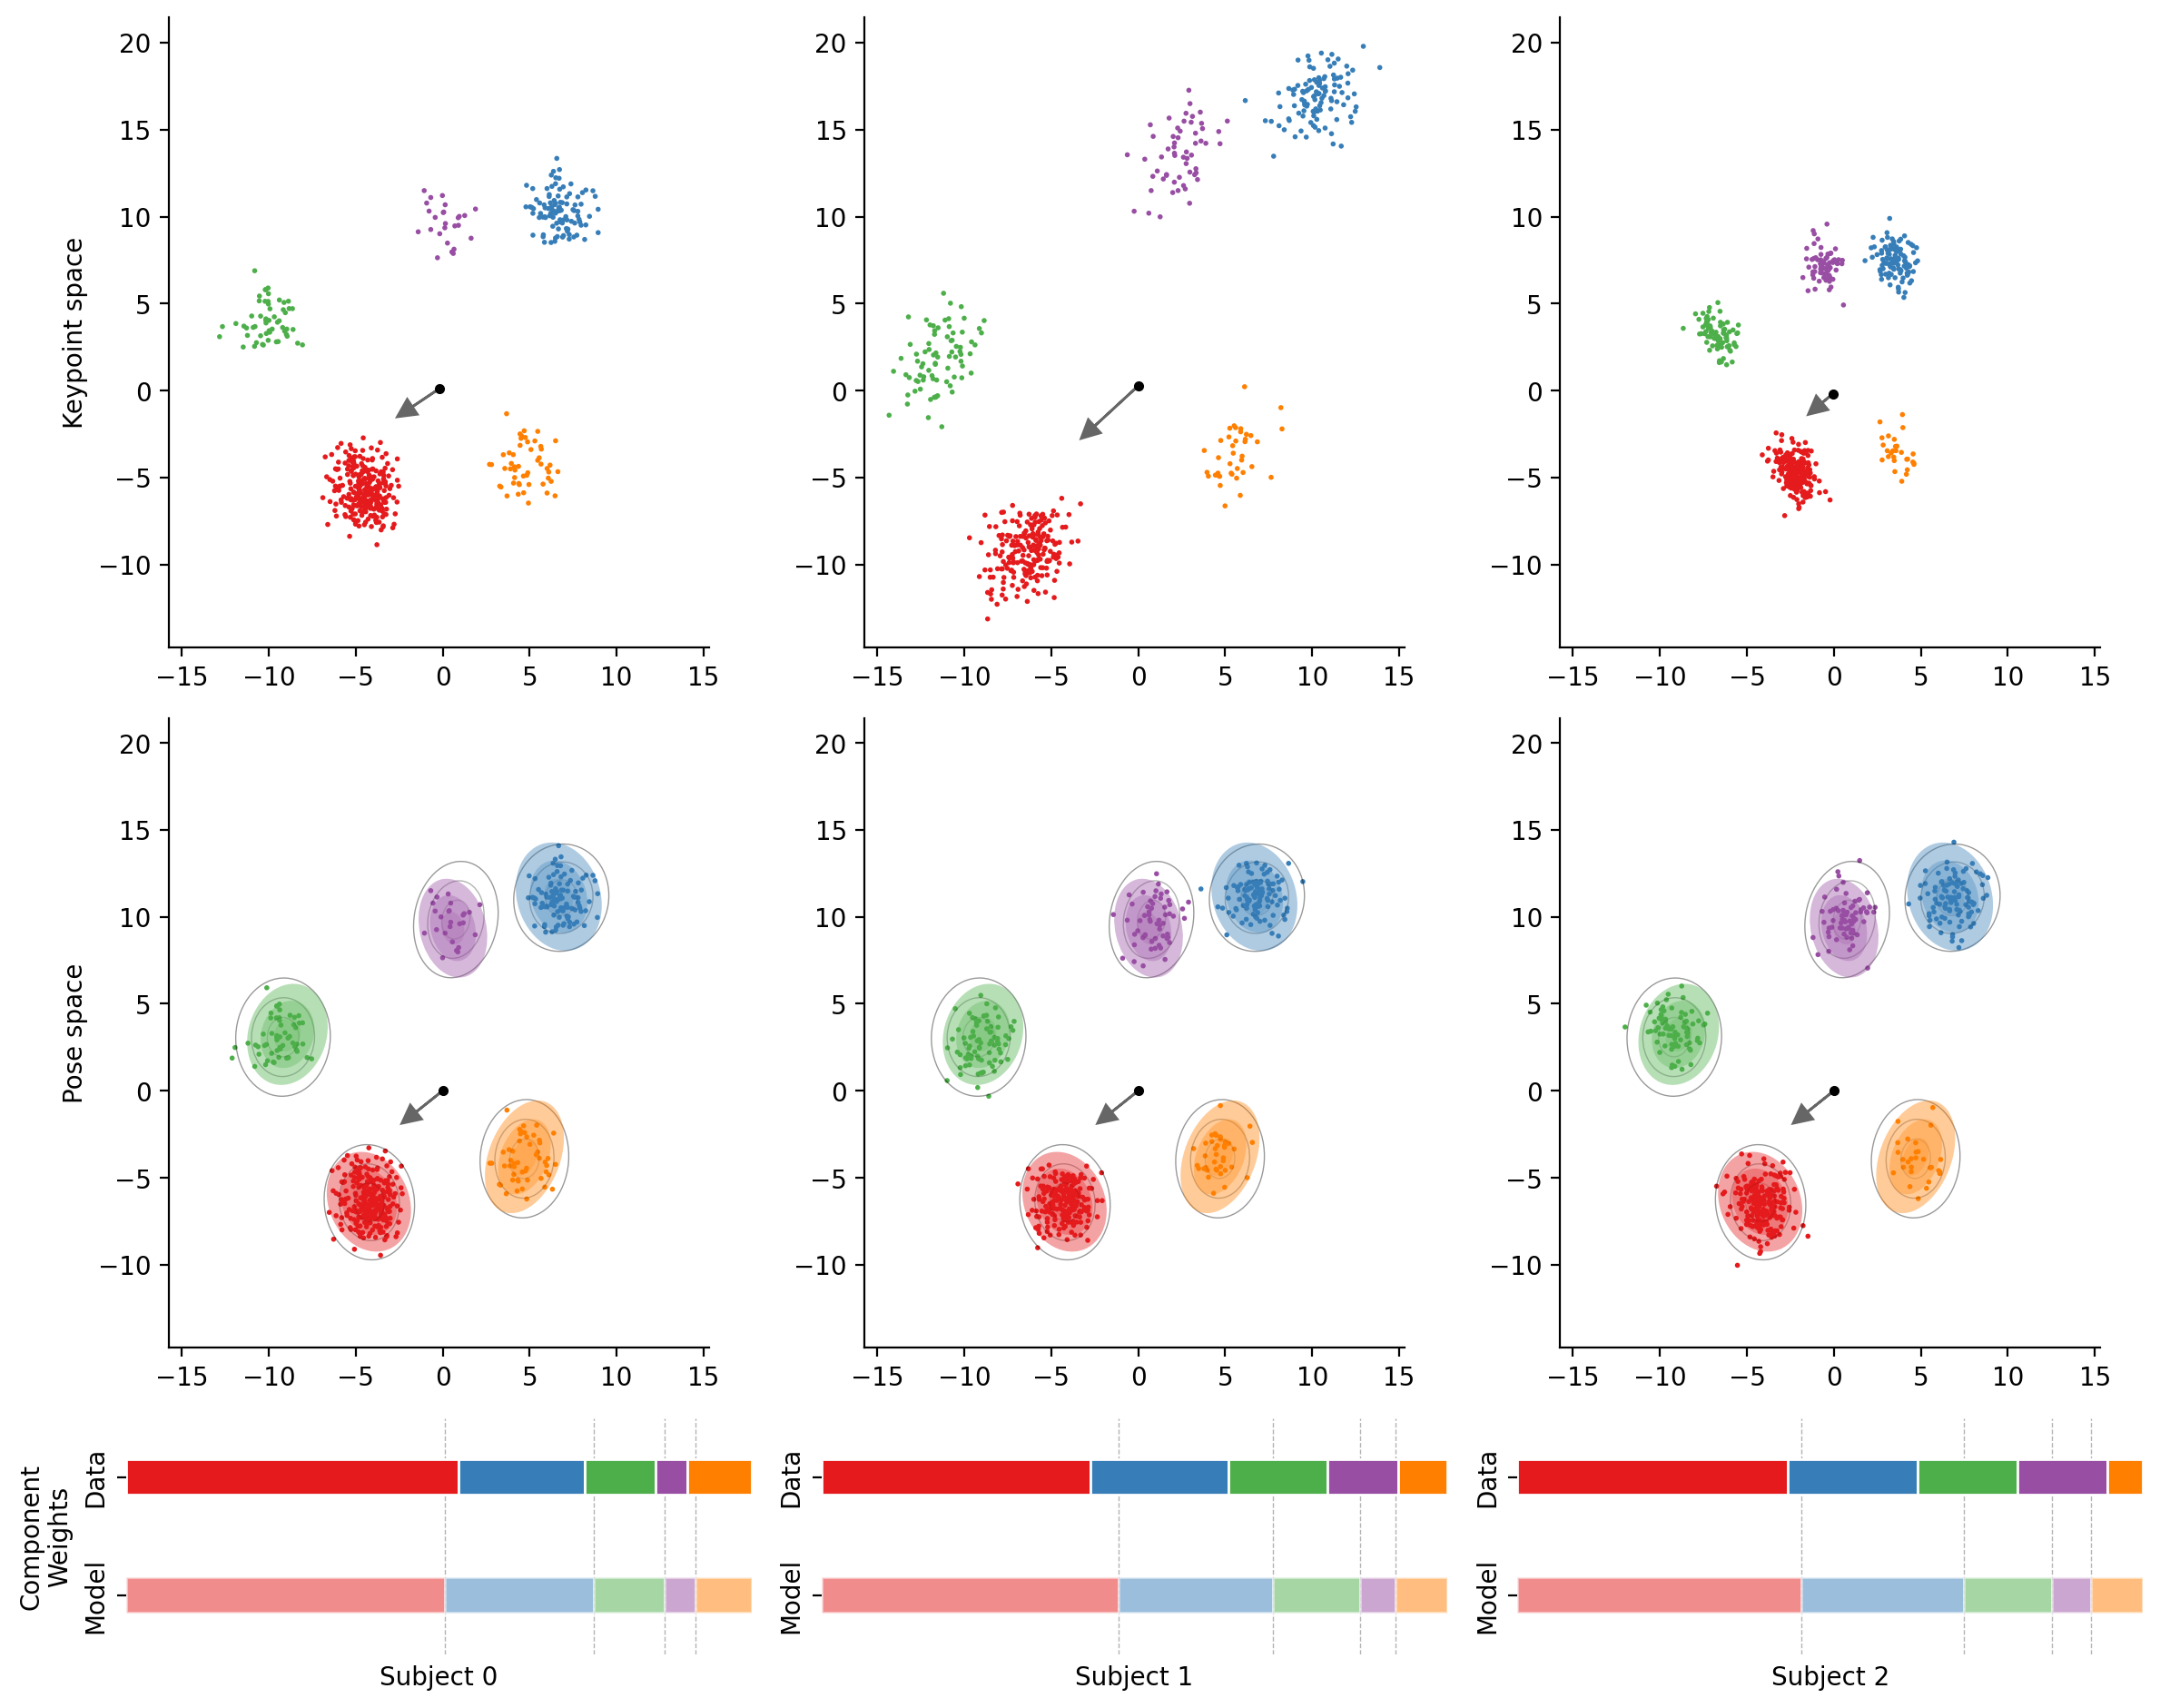

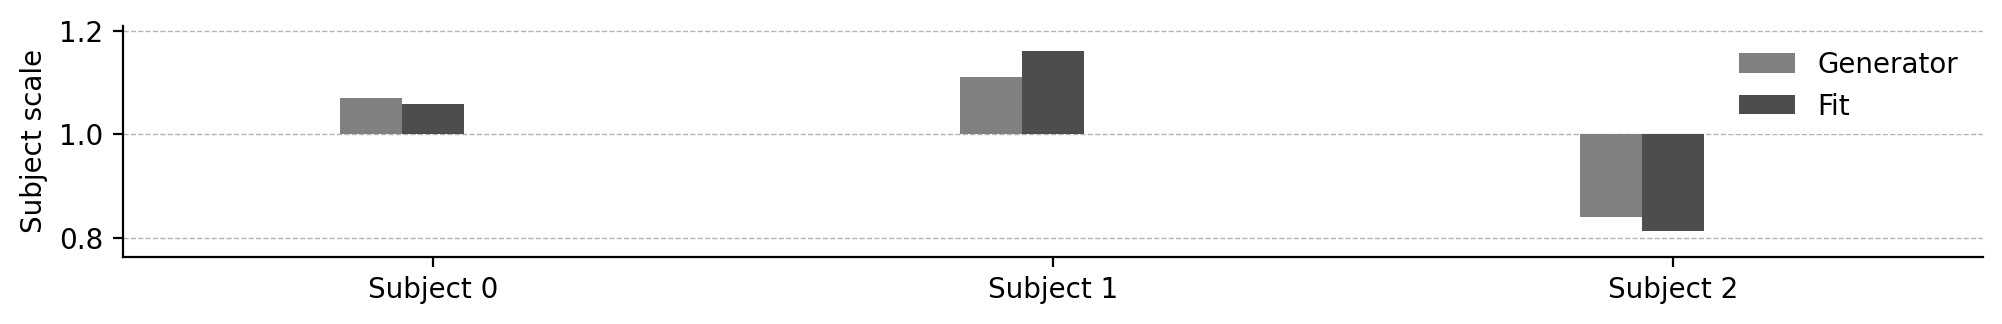

In [15]:
plot_step = param_hist[100]
fig = plt.figure(figsize = (4 * pose_hyperparams.N, 8 + 1.5 + 1.5))
est_states = joint_model.latent_mle(model, gt_obs, plot_step, hyperparams)
ax = mixtures.sampled_mixture_plot(fig, pose_hyperparams, plot_step.posespace, est_states, gt_obs)
viz_morphs.plot_morph_dimensions(
    ax, morph_hyperparams, afm.AffineModeMorph, plot_step.morph, display_scale = 3)
plt.show()

fig = plt.figure(figsize = (4 * pose_hyperparams.N, 1.5))
viz_morphs.plot_subjectwise_scalar_comparison(
    fig.gca(),
    [jnp.exp(gt_morph.uniform_scale()),
     jnp.exp(plot_step.morph.uniform_scale())],
    ["Generator", "Fit"],)

Observing that there is a local minimum around the PCA mode initialization that
the morph does not jump out of. For this generated data, there's no reason to
expect that PCA modes would be even approximately the best way to model the
observations, but we're hypothesizing that will not be the case for mouse data.

It would be nice to see convergence of randomly initialized mode vectors to
(approximately) that PC, or come up with inferior log likelihoods. Alternatively
some model-free observation that suggests that the first PC is a big axis of
variation between ages.